In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

print("Path to dataset files:", path)

100%|██████████| 788M/788M [00:10<00:00, 78.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1


In [4]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1"
print(os.listdir(dataset_path))


images_path = os.path.join(dataset_path, "PetImages")

# List contents inside PetImages
print(os.listdir(images_path))

['readme[1].txt', 'MSR-LA - 3467.docx', 'PetImages']
['Dog', 'Cat']


In [23]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# -----------------------------
# Setup and Data Path
# -----------------------------
# Defined the dataset path
# This folder contains 'Cat' and 'Dog' subfolders
# the device was set

images_path = os.path.join(dataset_path, "PetImages")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# 1. Data Preparation
# -----------------------------
# Here I defined my image transformation pipeline using torchvision.transforms.
# The images are resized to 150x150 pixels, randomly horizontally flipped for data augmentation,
# converted to tensors, and normalized with ImageNet mean and standard deviation.
# Next, I loaded the dataset using ImageFolder, expecting a folder structure with class subfolders.
# A balanced subset of 1,000 samples (500 from each class) is then created, and this subset
# is split into training (80%) and validation (20%) sets. Finally, I created DataLoaders for both.

data_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


full_dataset = datasets.ImageFolder(root=images_path, transform=data_transforms)
print("Total images found:", len(full_dataset))
print("Classes:", full_dataset.classes)


from PIL import Image, UnidentifiedImageError

def is_valid_image(filepath):
    try:
        with Image.open(filepath) as img:
            img.verify()  # Verify that it is, in fact, an image
        return True
    except (UnidentifiedImageError, OSError):
        return False

max_images = 10000
cat_indices = []
dog_indices = []

# Loop over the image file paths from the ImageFolder dataset and filter out invalid images
for i, (path, label) in enumerate(full_dataset.imgs):
    if not is_valid_image(path):
        continue  # Skip corrupted or unreadable images
    if label == 0 and len(cat_indices) < max_images:
        cat_indices.append(i)
    elif label == 1 and len(dog_indices) < max_images:
        dog_indices.append(i)

selected_indices = cat_indices + dog_indices



dataset = torch.utils.data.Subset(full_dataset, selected_indices)
print("Balanced subset size:", len(dataset))


train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Training samples: {len(train_dataset)} | Validation samples: {len(val_dataset)}")


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)









Using device: cpu
Total images found: 25000
Classes: ['Cat', 'Dog']
Balanced subset size: 20000
Training samples: 18000 | Validation samples: 2000


In [10]:

# 2. CNN Modell Implementation
# -----------------------------
# This section defines the CNN model used for image classification.
# The network consists of three convolutional blocks for feature extraction,
# where each block applies convolution, ReLU activation, and max pooling.
# After these layers, the output is flattened and passed through two fully connected layers
# (with dropout applied) to output a prediction for two classes (Cat and Dog).





class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Reduces spatial size by factor of 2

            # 2nd Conv block: 32 -> 64 channels
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # 3rd Conv block: 64 -> 128 channels
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 18 * 18, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CNNModel().to(device)
print(model)

# 3. Training Setup
# -----------------------------
# In the training setup section, I defined the loss function and optimizer.
# I used CrossEntropyLoss as my loss criterion (suitable for multi-class classification)
# and the Adam optimizer with a learning rate of 0.001.
# This configuration will be used in my training loop  to update model weights.


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=41472, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [ ]:
import torch

num_epochs = 6
best_val_acc = 0.0  # Track best validation accuracy
best_checkpoint_path = "best_model_checkpoint.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%")

    # Save a checkpoint for this epoch
    checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': epoch_loss,
        'train_acc': epoch_acc,
        'val_loss': val_epoch_loss,
        'val_acc': val_epoch_acc
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

    # Update best checkpoint if current validation accuracy is the highest so far
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_loss,
            'train_acc': epoch_acc,
            'val_loss': val_epoch_loss,
            'val_acc': val_epoch_acc
        }, best_checkpoint_path)
        print(f"Best model updated at epoch {epoch+1} with Val Acc: {val_epoch_acc:.2f}%")

    # Stop training if validation accuracy drops below 75%
    if val_epoch_acc < 75:
        print("Stopping training as validation accuracy dropped below 75%.")
        break

# After training, you can revert to the best model state:
checkpoint = torch.load(best_checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"Reverted to best checkpoint from epoch {checkpoint['epoch']} with Val Acc: {checkpoint['val_acc']:.2f}%")


Epoch [1/6] Train Loss: 0.3713, Train Acc: 84.04% | Val Loss: 0.3227, Val Acc: 86.30%
Checkpoint saved: checkpoint_epoch_1.pth
Best model updated at epoch 1 with Val Acc: 86.30%


In [24]:
# Save checkpoint after initial training
checkpoint = {
    'epoch': epoch,  # last completed epoch
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': epoch_loss,
}

torch.save(checkpoint, 'initial_checkpoint.pth')
print("Checkpoint saved!")


Checkpoint saved!


In [25]:
# Load checkpoint
checkpoint = torch.load('initial_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


<ipython-input-25-89b1f057619d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('initial_checkpoint.pth')


In [20]:
# -----------------------------
# 5. Final Evaluation Metrics
# -----------------------------
# In this final evaluation phase, I generated a classification report and confusion matrix
# to assess my model’s performance on the validation set. I explicitly specify labels=[0, 1]
# to match the two classes (Cat and Dog), and I used the class names from the full dataset.


print("\nClassification Report on Validation Set:")
print(classification_report(all_labels, all_preds,
      target_names=full_dataset.classes, labels=[0, 1]))

print("Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
print(cm)



Classification Report on Validation Set:
              precision    recall  f1-score   support

         Cat       0.85      0.74      0.79       985
         Dog       0.77      0.87      0.82      1015

    accuracy                           0.80      2000
   macro avg       0.81      0.80      0.80      2000
weighted avg       0.81      0.80      0.80      2000

Confusion Matrix:
[[727 258]
 [133 882]]


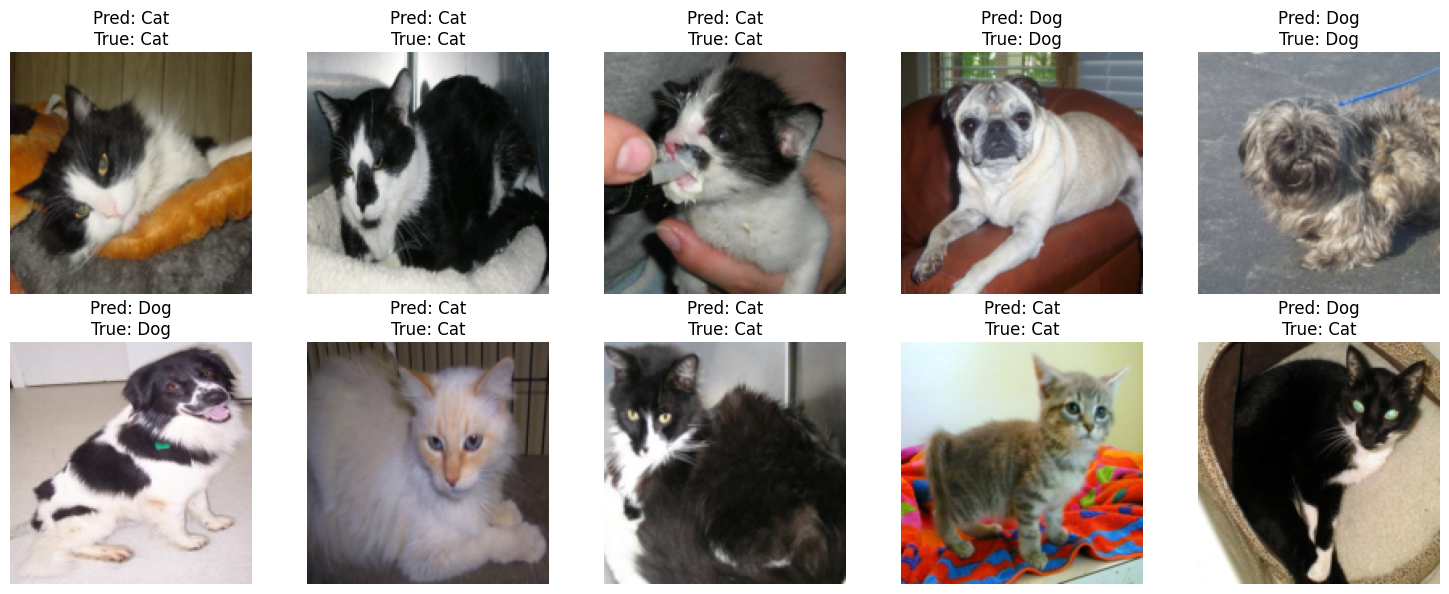

In [21]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch

# ---------------------------------------------------------------------------------
# Image Visualization Utility
# In this section, I define a helper function called `imshow` that takes a normalized
# tensor image (in the format CxHxW), converts it to a NumPy array in HxWxC order,
# unnormalizes it using the same mean and standard deviation values used during training,
# and then displays the image using Matplotlib. This function also allows an optional title.


def imshow(img, title=None):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# ---------------------------------------------------------------------------------
# Selecting and Processing Random Validation Images
# ---------------------------------------------------------------------------------
# In this section, I set the model to evaluation mode and randomly select 10 images
# from the validation dataset. For each selected image, I obtained its true label and
# compute the predicted label by performing a forward pass through the model. I store
# the images, true labels, and predicted labels in separate lists for later visualization.

model.eval()

indices = random.sample(range(len(val_dataset)), 10)
images = []
true_labels = []
predicted_labels = []

with torch.no_grad():
    for idx in indices:
        # Get the image and its true label from the validation set
        image, label = val_dataset[idx]
        true_labels.append(label)
        images.append(image)

        # Prepare the image for model input by adding a batch dimension and moving it to the device
        input_image = image.unsqueeze(0).to(device)
        output = model(input_image)
        _, pred = torch.max(output, 1)
        predicted_labels.append(pred.item())

# ---------------------------------------------------------------------------------
# Visualizing Predictions
# ---------------------------------------------------------------------------------
# In this final section, I retrieved the class names from the full dataset and plot the
# 10 selected images in a 2x5 grid using Matplotlib. Each image is annotated with both
# its predicted and true class labels to help assess the model's performance visually.
class_names = full_dataset.classes

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    title = f"Pred: {class_names[predicted_labels[i]]}\nTrue: {class_names[true_labels[i]]}"
    plt.sca(ax)
    imshow(images[i], title=title)

plt.tight_layout()
plt.show()
